# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch.unitroot import PhillipsPerron
from pmdarima import auto_arima
from pmdarima.arima import ndiffs

In [2]:
plt.style.use('ggplot')

# Read the data

In [3]:
df_apple = pd.read_csv('./data/df_apple.csv')
df_samsung = pd.read_csv('./data/df_samsung.csv')

In [4]:
df_apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2015,27.847500,27.860001,26.837500,27.332500,24.898552,212818400
1,05/01/2015,27.072500,27.162500,26.352501,26.562500,24.197117,257142000
2,06/01/2015,26.635000,26.857500,26.157499,26.565001,24.199400,263188400
3,07/01/2015,26.799999,27.049999,26.674999,26.937500,24.538729,160423600
4,08/01/2015,27.307501,28.037500,27.174999,27.972500,25.481558,237458000


In [5]:
df_samsung.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2015,26800.0,26800.0,26540.0,26600.0,257.958313,8774950.0
1,05/01/2015,26720.0,26720.0,26260.0,26660.0,258.540161,10139500.0
2,06/01/2015,26300.0,26340.0,25760.0,25900.0,251.169937,15235500.0
3,07/01/2015,25880.0,26220.0,25640.0,26140.0,253.497406,14322750.0
4,08/01/2015,26780.0,26780.0,26200.0,26280.0,254.855087,14477600.0


# Analysis

In [6]:
df_apple.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df_samsung.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [8]:
# remove null values

df_samsung[df_samsung.isnull().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume
686,16/11/2017,NaN,NaN,NaN,NaN,NaN,NaN
714,02/01/2018,NaN,NaN,NaN,NaN,NaN,NaN
921,15/11/2018,NaN,NaN,NaN,NaN,NaN,NaN
1158,14/11/2019,NaN,NaN,NaN,NaN,NaN,NaN


Removed null values manually (from both csvs)

In [9]:
df_apple_final = pd.read_csv('./data/df_apple_final.csv')
df_samsung_final = pd.read_csv('./data/df_samsung_final.csv')

In [10]:
df_apple_final.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df_samsung_final.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [12]:
df_apple_final.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [13]:
df_samsung_final.dtypes

Date          object
Open           int64
High           int64
Low            int64
Close          int64
Adj Close    float64
Volume         int64
dtype: object

# APPLE vs. SAMSUNG

In [14]:
df_apple_final['Date'] = pd.to_datetime(df_apple_final['Date'], format = '%d/%m/%Y')

In [15]:
df_apple_final.set_index('Date', inplace = True)

<AxesSubplot:title={'center':'Evolution of closing prices (APPLE stocks)'}, xlabel='Date'>

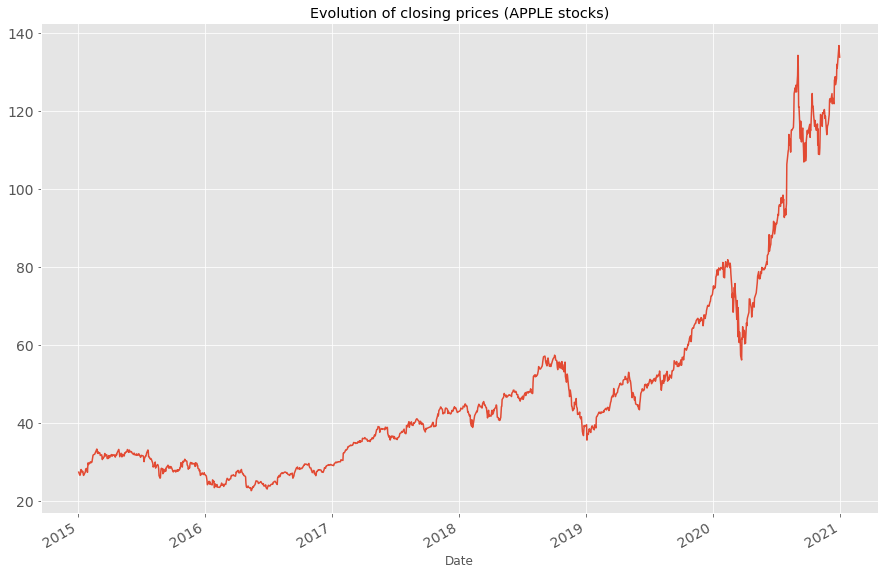

In [16]:
df_apple_final['Close'].plot(figsize = (15, 10), title = 'Evolution of closing prices (APPLE stocks)', fontsize = 14)

In [17]:
df_samsung_final['Date'] = pd.to_datetime(df_samsung_final['Date'], format = '%d/%m/%Y')

In [18]:
df_samsung_final.set_index('Date', inplace = True)

<AxesSubplot:title={'center':'Evolution of closing prices (SAMSUNG stocks)'}, xlabel='Date'>

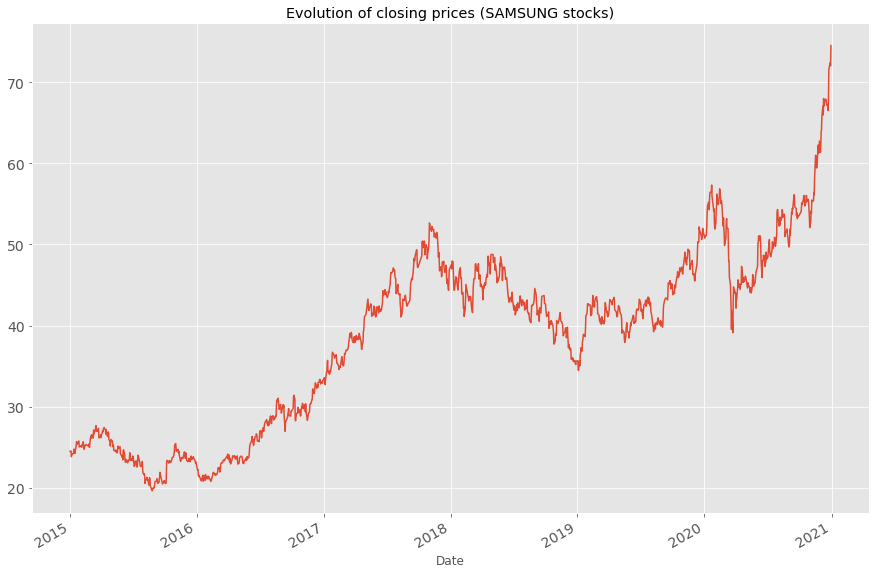

In [19]:
# convert KRW into $
df_samsung_final['Close'] = df_samsung_final['Close'] * 0.00092

df_samsung_final['Close'].plot(figsize = (15, 10), title = 'Evolution of closing prices (SAMSUNG stocks)', fontsize = 14)

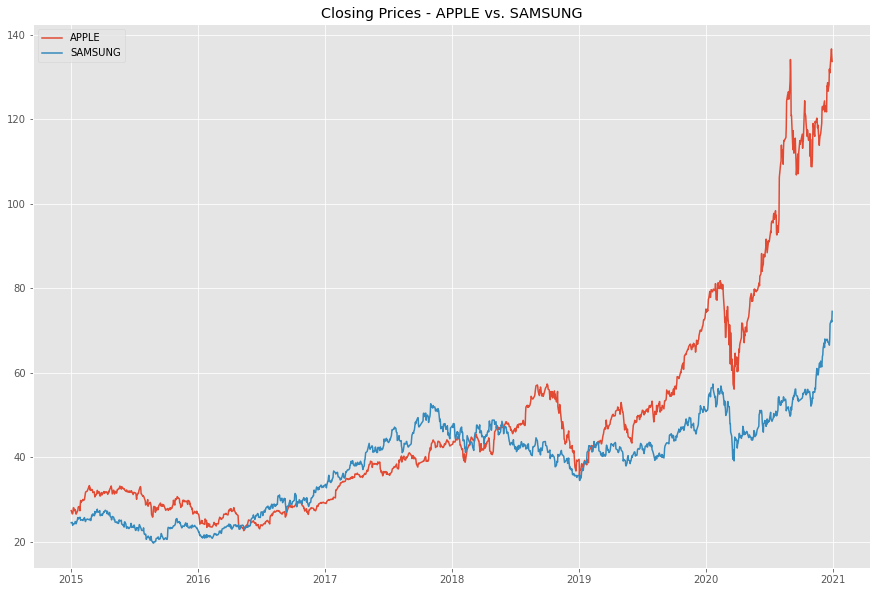

In [20]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(df_apple_final['Close'], label = 'APPLE')
ax.plot(df_samsung_final['Close'], label = 'SAMSUNG')
ax.set_title('Closing Prices - APPLE vs. SAMSUNG')
ax.legend()

# ARIMA

In [21]:
from statsmodels.tsa.stattools import adfuller

In [22]:
X_train = df_apple_final[:1185]
X_test = df_apple_final[1185:]

In [23]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (1185, 6)
X_test shape: (241, 6)


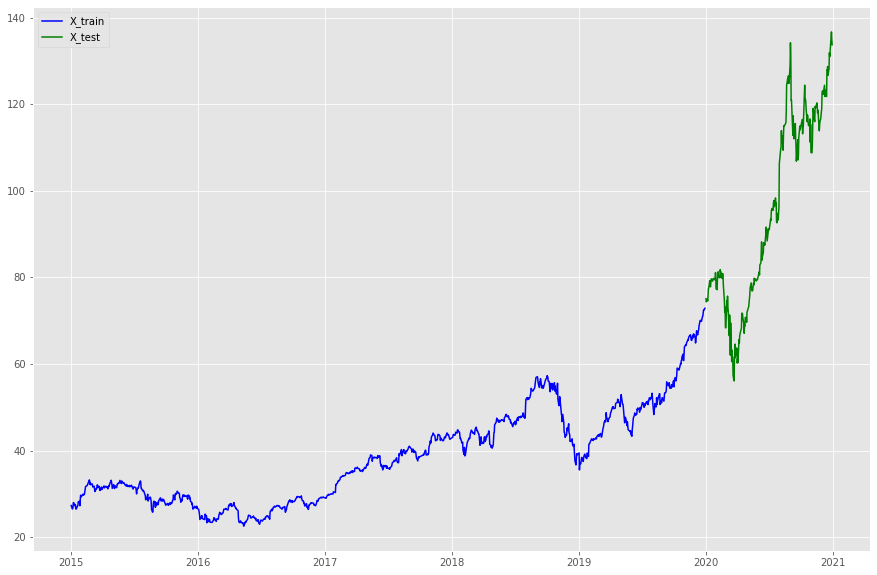

In [24]:
fig, ax = plt.subplots(figsize = (15, 10))
ax.plot(X_train['Close'], label = 'X_train', color = 'blue')
ax.plot(X_test['Close'], label = 'X_test', color = 'green')
ax.legend()

In [34]:
# test for stationarity

def test_stationarity(time_serie):
    
    # determining rolling statistics
    rolling_mean = time_serie.rolling(30).mean() # 30 days
    rolling_std = time_serie.rolling(30).std() # 30 days
    
    # plot rolling statistics
    plt.plot(time_serie, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
    # perform dickey-fuller test
    print('Results of Dickey-Fuller Test:')
    
    dickey_fuller_test = adfuller(time_serie, autolag = 'AIC')
    dickey_fuller_output = pd.Series(dickey_fuller_test[0:4], index = ['Test Statistic', 'P-value', 'No. of Lags Used', 'Number of Observations'])
    
    for key, value in dickey_fuller_test[4].items():
        dickey_fuller_output['Critical Value (%s)' %key] = value
        
    print(dickey_fuller_output)

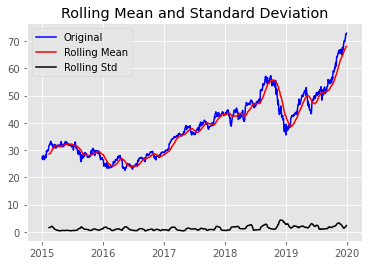

Results of Dickey-Fuller Test:
Test Statistic               1.173064
P-value                      0.995794
No. of Lags Used             0.000000
Number of Observations    1184.000000
Critical Value (1%)         -3.435885
Critical Value (5%)         -2.863984
Critical Value (10%)        -2.568071
dtype: float64


In [26]:
test_stationarity(X_train['Close'])

In [85]:
ndiffs(X_train['Close'], test = 'kpss', max_d = 50)

1

In [28]:
ndiffs(X_train['Close'], test = 'adf', max_d = 50)

1

In [29]:
ndiffs(X_train['Close'], test = 'pp', max_d = 50)

1

In [30]:
close_diff_1 = X_train['Close'].diff()

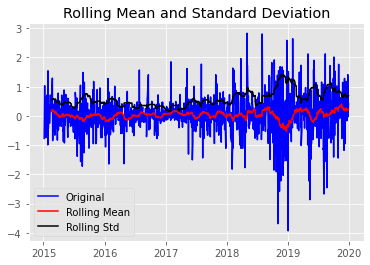

In [33]:
test_stationarity(close_diff_1)

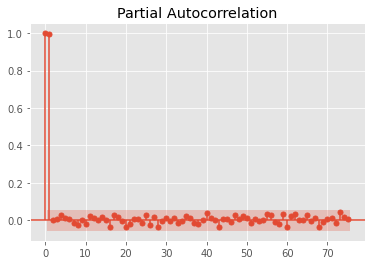

In [35]:
plot_pacf(X_train['Close'], lags = 75)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2302.300, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2311.913, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2313.704, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2313.688, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2314.166, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2301.948, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2314.233, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2315.253, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2303.843, Time=0.56 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2315.953, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2301.866, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2314.285, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2303.732, Time=0.55 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2316.139, Time=0.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept

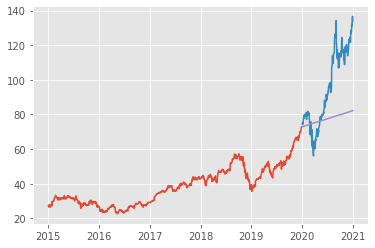

In [36]:
# building the model

model = auto_arima(X_train['Close'], trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(X_train['Close'])

forecast = model.predict(n_periods = len(X_test['Close']))
forecast = pd.DataFrame(forecast, index = X_test['Close'].index, columns = ['Prediction'])

# plot the predictions for the test set
plt.plot(X_train['Close'], label = 'Train')
plt.plot(X_test['Close'], label = 'Test')
plt.plot(forecast, label = 'Prediction')
plt.show()

In [37]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1185
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1145.933
Date:                Wed, 20 Jan 2021   AIC                           2301.866
Time:                        15:30:55   BIC                           2327.250
Sample:                             0   HQIC                          2311.434
                               - 1185                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0766      0.036      2.118      0.034       0.006       0.147
ar.L1         -0.9318      0.038    -24.824      0.000      -1.005      -0.858
ar.L2         -0.0562      0.021     -2.636      0.008      -0.098      -0.014
ma.L1          0.9304      0.028     32.945      0.000       0.875       0.986
sigma2         0.4056      0.010     42.374      0.000       0.387       0.424
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               966.21
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               3.44   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# VAR

In [137]:
import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

In [39]:
print('df_apple_final shape: ', df_apple_final.shape)
print('df_samsung_final shape: ', df_samsung_final.shape)

df_apple_final shape:  (1426, 6)
df_samsung_final shape:  (1426, 6)


In [40]:
# merge the dataframes

df_apple_samsung = pd.DataFrame({'apple_close_price': df_apple_final['Close'], 'samsung_close_price': df_samsung_final['Close']})

In [41]:
df_apple_samsung.head()

,apple_close_price,samsung_close_price
Date,,
2015-01-02,27.332500,24.4720
2015-01-05,26.562500,24.5272
2015-01-06,26.565001,23.8280
2015-01-07,26.937500,24.0488
2015-01-08,27.972500,24.1776


In [42]:
granger_test = grangercausalitytests(df_apple_samsung, maxlag = 2, verbose = True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7663  , p=0.1841  , df_denom=1422, df_num=1
ssr based chi2 test:   chi2=1.7700  , p=0.1834  , df=1
likelihood ratio test: chi2=1.7689  , p=0.1835  , df=1
parameter F test:         F=1.7663  , p=0.1841  , df_denom=1422, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1078  , p=0.0166  , df_denom=1419, df_num=2
ssr based chi2 test:   chi2=8.2445  , p=0.0162  , df=2
likelihood ratio test: chi2=8.2208  , p=0.0164  , df=2
parameter F test:         F=4.1078  , p=0.0166  , df_denom=1419, df_num=2


In [71]:
def grangers_causality_matrix(data, variables, test, max_lag = 2, verbose = False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)

    for c in dataset.columns:
        for r in dataset.index:
            
            test_result = grangercausalitytests(data[[r, c]], maxlag = max_lag, verbose = False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(max_lag)]
            
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r, c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

In [72]:
grangers_causality_matrix(df_apple_samsung, variables = df_apple_samsung.columns, test = 'ssr_chi2test')

,apple_close_price_x,samsung_close_price_x
apple_close_price_y,1.0,0.0162
samsung_close_price_y,0.0,1.0000


In [86]:
# test for stationarity

def test_stationarity(time_serie):
    
    # determining rolling statistics
    rolling_mean = time_serie.rolling(30).mean() # 30 days
    rolling_std = time_serie.rolling(30).std() # 30 days
    
    # plot rolling statistics
    plt.plot(time_serie, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
#     # perform dickey-fuller test
#     print('Results of Dickey-Fuller Test:')
    
#     dickey_fuller_test = adfuller(time_serie, autolag = 'AIC')
#     dickey_fuller_output = pd.Series(dickey_fuller_test[0:4], index = ['Test Statistic', 'P-value', 'No. of Lags Used', 'Number of Observations'])
    
#     for key, value in dickey_fuller_test[4].items():
#         dickey_fuller_output['Critical Value (%s)' %key] = value
        
#     print(dickey_fuller_output)

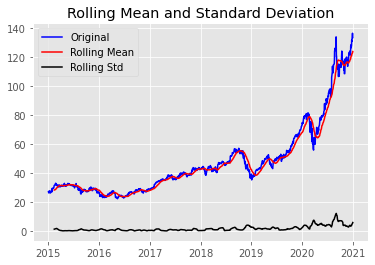

Results of Dickey-Fuller Test:
Test Statistic               2.565095
P-value                      0.999068
No. of Lags Used            23.000000
Number of Observations    1402.000000
Critical Value (1%)         -3.435023
Critical Value (5%)         -2.863604
Critical Value (10%)        -2.567869
dtype: float64


In [77]:
test_stationarity(df_apple_samsung['apple_close_price'])

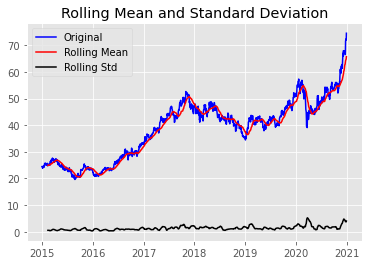

Results of Dickey-Fuller Test:
Test Statistic               0.658021
P-value                      0.988962
No. of Lags Used             0.000000
Number of Observations    1425.000000
Critical Value (1%)         -3.434947
Critical Value (5%)         -2.863570
Critical Value (10%)        -2.567851
dtype: float64


In [78]:
test_stationarity(df_apple_samsung['samsung_close_price'])

In [79]:
ndiffs(df_apple_samsung['apple_close_price'], test = 'kpss', max_d = 50)

2

In [80]:
ndiffs(df_apple_samsung['apple_close_price'], test = 'adf', max_d = 50)

1

In [81]:
ndiffs(df_apple_samsung['apple_close_price'], test = 'pp', max_d = 50)

1

In [82]:
ndiffs(df_apple_samsung['samsung_close_price'], test = 'kpss', max_d = 50)

1

In [83]:
ndiffs(df_apple_samsung['samsung_close_price'], test = 'adf', max_d = 50)

1

In [84]:
ndiffs(df_apple_samsung['samsung_close_price'], test = 'pp', max_d = 50)

1

In [110]:
df_apple_samsung['apple_close_price'] = df_apple_samsung['apple_close_price'].diff()

In [113]:
df_apple_samsung['samsung_close_price'] = df_apple_samsung['samsung_close_price'].diff()

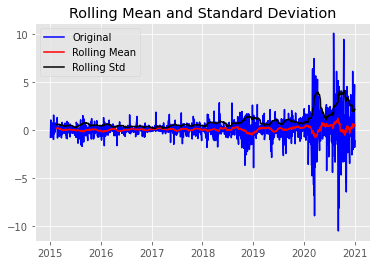

In [114]:
test_stationarity(df_apple_samsung['apple_close_price'])

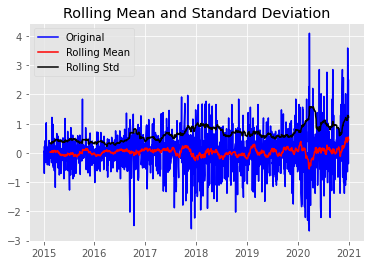

In [115]:
test_stationarity(df_apple_samsung['samsung_close_price'])

In [281]:
df_apple_samsung.head()

,apple_close_price,samsung_close_price
Date,,
2015-01-02,NaN,NaN
2015-01-05,-0.770000,0.0552
2015-01-06,0.002501,-0.6992
2015-01-07,0.372499,0.2208
2015-01-08,1.035000,0.1288


In [268]:
print('df_apple_samsung shape: ', df_apple_samsung.shape)

df_apple_samsung shape:  (1426, 2)


In [512]:
# split the dataframe into 2 parts

# df_train = df_apple_samsung[:1390]
# df_test = df_apple_samsung[1390:1400]

df_train = df_apple_samsung[:1250]
df_test = df_apple_samsung[1250:1255]

In [513]:
# delete the first line

df_train = df_train.iloc[1:]

In [514]:
# some preprocessing steps for avoiding warnings

df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

In [515]:
var_model = VAR(df_train)
var_model.select_order(maxlags = 15).summary()

,AIC,BIC,FPE,HQIC
0,-1.050,-1.041,0.3501,-1.046
1,-1.140,-1.115*,0.3199,-1.130
2,-1.141,-1.099,0.3196,-1.125
3,-1.139,-1.081,0.3202,-1.117
4,-1.166,-1.092,0.3115,-1.138
5,-1.180,-1.089,0.3072,-1.146
6,-1.182,-1.074,0.3066,-1.142
7,-1.218,-1.093,0.2959,-1.171
8,-1.246,-1.105,0.2876,-1.193
9,-1.270*,-1.112,0.2809*,-1.211*


In [516]:
var_results = var_model.fit(9)
var_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 22, Jan, 2021
Time:                     09:54:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.11871
Nobs:                     1240.00    HQIC:                  -1.21666
Log likelihood:          -2690.03    FPE:                   0.279236
AIC:                     -1.27570    Det(Omega_mle):        0.270872
--------------------------------------------------------------------
Results for equation apple_close_price
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.028689         0.023562            1.218           0.223
L1.apple_close_price          -0.145345         0.028658           -5.072           0.000
L1.samsung_c

In [517]:
predictions = var_results.forecast(df_train.values[-9:], steps = len(df_test))

In [529]:
df_actuals_predictions = pd.DataFrame({'Actual prices (apple stocks)': df_test.iloc[:, 0], 'Actual prices (samsung stocks)': df_test.iloc[:, 1], 'Predicted prices (apple stocks)': predictions[:, 0], 'Predicted prices (samsung stocks)': predictions[:, 1]})

In [530]:
df_actuals_predictions.head()

,Actual prices (apple stocks),Actual prices (samsung stocks),Predicted prices (apple stocks),Predicted prices (samsung stocks)
Date,,,,
2020-04-08,1.660004,-0.920,1.263036,-0.308015
2020-04-09,0.479996,0.460,-0.423785,0.444479
2020-04-13,1.315002,-0.736,-0.546481,-0.412900
2020-04-14,3.449997,0.644,1.206005,0.136278
2020-04-16,-0.089996,0.000,-1.466767,-0.112393


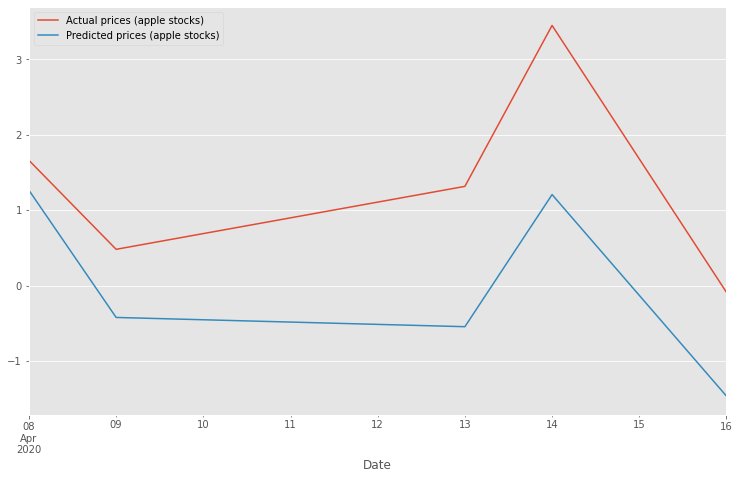

In [536]:
fig, ax = plt.subplots(figsize = (12.5, 7.5))
df_actuals_predictions.iloc[:, 0].plot(ax = ax)
df_actuals_predictions.iloc[:, 2].plot(ax = ax)
plt.legend()
plt.show()

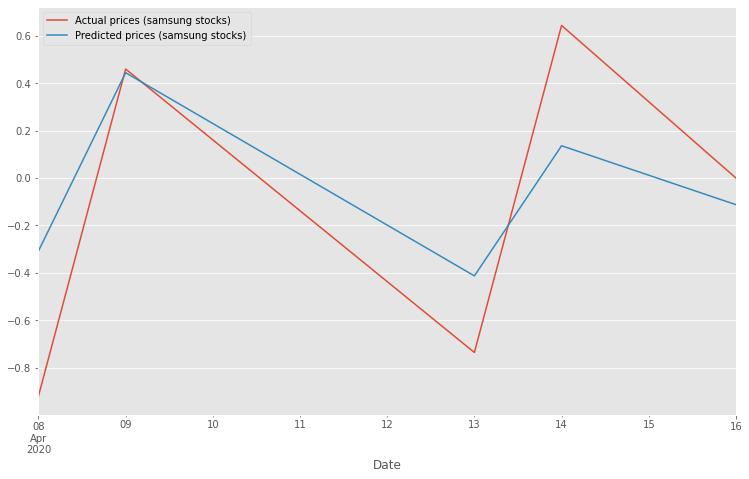

In [537]:
fig, ax = plt.subplots(figsize = (12.5, 7.5))
df_actuals_predictions.iloc[:, 1].plot(ax = ax)
df_actuals_predictions.iloc[:, 3].plot(ax = ax)
plt.legend()
plt.show()